c:\users\oliver\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "c:\users\oliver\appdata\local\programs\python\python36-32\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\oliver\appdata\local\programs\python\python36-32\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\oliver\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\oliver\appdata\local\programs\python\python36-32\lib\site-packages\traitlets\config\application.py", line 658, in launch_ins

Pipeline(memory=Memory(cachedir='/tmp/py_sklearn_tmpndu9u8c7\\joblib'),
     steps=[('scale', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('reduce_dim', LinearDiscriminantAnalysis(n_components=9, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)), ('classify', SVC(C=1000000.0...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
Pipeline(memory=Memory(cachedir='/tmp/py_sklearn_tmpsxxpukca\\joblib'),
     steps=[('scale', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('reduce_dim', FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=284, random_state=None, tol=0.0001, w_init=None,
    whiten=True)), ('class...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
----GridSearch Cross-Validation Scor

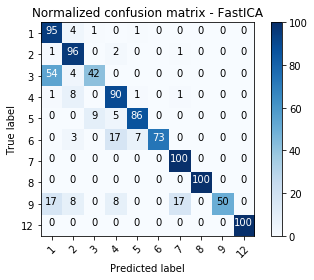

In [5]:
import MySegments
import MyVisualiser
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.externals import joblib

import os
from os import path
from os import mkdir
from os import listdir
from os.path import isfile, join

import datetime
now = datetime.datetime.now()

import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import itertools
from sklearn.metrics import confusion_matrix

def plot_test_time(model, df,ax):
    #Plotting the the accuracy over number of features
    #Get best mean_train_score per Selection Method and number of features
    df_m = (df.assign(rn=df.sort_values(['rank_test_score'], ascending=True)
                .groupby(['reducer','n_features'])
                .cumcount()+1)
                .query('rn<2')
    )
    reducers = df_m['reducer'].drop_duplicates().tolist()
    COLORS = 'bgrcmyk'  
    
    for color,reducer_label in zip(COLORS,reducers):
        if reducer_label != '': #Labels to exclude!
            reducer = df_m[df_m['reducer'] == reducer_label][['n_features','mean_score_time','mean_fit_time', 'std_score_time', 'std_fit_time']]
            reducer = reducer.sort_values('n_features')

            #----full line for mean
            ax.plot(reducer['n_features'],reducer['mean_score_time'], '-', label='score time')  
            ax.fill_between(x=reducer['n_features'], 
                             y1=reducer['mean_score_time']-reducer['std_score_time'], 
                             y2=reducer['mean_score_time']+reducer['std_score_time'],
                             alpha =0.2, interpolate = True)
            #----filled area for std
            ax.plot(reducer['n_features'],reducer['mean_fit_time'], '-', label='fit time')
            ax.fill_between(x=reducer['n_features'], 
                             y1=reducer['mean_fit_time']-reducer['std_fit_time'], 
                             y2=reducer['mean_fit_time']+reducer['std_fit_time'],
                             alpha =0.2, interpolate = True)
  #  plt.tight_layout()
    ax.legend(loc='upper center')
    ax.set_title('Performance - ' + model)
    ax.set_xlabel('Number of Features')
    ax.set_xscale('log', base=2)
    ax.set_xticks([1,2,5,10,20,50,100,200,500])
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    
    ax.set_ylabel('Time in seconds')
    ax.grid(b=True, which='major', linestyle='-', alpha=0.6)
    ax.grid(b=True, which='minor', linestyle='--', alpha=0.3)
    ax.minorticks_on()

def plot_learning_curve(model, train_sizes, train_scores, valid_scores, ax):
  #  plt.figure('train_size')
    
    ax.grid(b=True, which='major', linestyle='-', alpha=0.6)
    ax.grid(b=True, which='minor', linestyle='--', alpha=0.3)
    ax.minorticks_on()
    ax.set_ylim(ymin=0.17, ymax=1.03)
    ax.plot(train_sizes,np.mean(train_scores, axis = 1), '-', label ='train scores')
    ax.fill_between(x=train_sizes,
                         y1=np.mean(train_scores, axis = 1)-np.std(train_scores, axis = 1),
                         y2=np.mean(train_scores, axis = 1)+np.std(train_scores, axis = 1), 
                         alpha =0.2, interpolate = True)
    ax.plot(train_sizes,np.mean(valid_scores, axis = 1), '-', label ='validation scores')
    ax.fill_between(x=train_sizes,
                         y1=np.mean(valid_scores, axis = 1)-np.std(valid_scores, axis = 1),
                         y2=np.mean(valid_scores, axis = 1)+np.std(valid_scores, axis = 1),
                         alpha =0.2, interpolate = True)
    ax.legend(loc='lower right')
    
    ax.set_xscale('log', base=2)
    ax.set_xticks([0.02,0.05,0.1,0.2,0.5,1.0])
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    
    ax.set_title('Learning curve - ' + model)
    ax.set_xlabel('Train-test-ratio')
    ax.set_ylabel('Accuracy')  


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm*100 if normalize else cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.0f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]*100, fmt) if normalize else format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

   # plt.tight_layout()
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')





models = ['LDA', 'FastICA']#, 'PCA', 'IncPCA', 'Select_ANOVA', 'Select_Chi2', 'Select_Mutual_Info']
clfs = []
cv_results = []

#load best estimators and cv results
for model in models:    
    for file in os.listdir('./Results/'+ model):
        if file.endswith('.pkl'):
            #print(os.path.join('./Results/' + model, file))
            clfs.append(joblib.load(os.path.join('./Results/' + model, file)))
            print(joblib.load(os.path.join('./Results/' + model, file)))
        if file.endswith('.csv'):
            cv_results.append(pd.read_csv(os.path.join('./Results/' + model, file), sep='\t'))#, header=1))

#Load Data
mypath = 'Test'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    
#Get labelled data
sc = MySegments.SegmentCollection(folder = mypath, segments_path=onlyfiles, labels_path = 'labels.csv', classes_path='class_names.csv')
idx,X,y = sc.get_labelled()

#split train and test data, maintaining class distributions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)

print('----GridSearch Cross-Validation Score----')
for model, clf, cv_result in zip(models, clfs, cv_results):    
    print(model, cv_result.sort_values(['rank_test_score'], ascending=True)['mean_test_score'].head(1).values)

print('----Performance on Unseen Data----')
for i,(model, clf, cv_result) in enumerate(zip(models, clfs, cv_results)):   
    clf.fit(X_train,y_train)
    print(model, clf.score(X_test, y_test))

#plot individually    
print('----Test Time----')
for i,(model, clf, cv_result) in enumerate(zip(models, clfs, cv_results)):
    plt.clf()
    fig, ax = plt.subplots(nrows=1,ncols=1, num='test_time', figsize=(5,4))
    plot_test_time(model, cv_result, ax)
    fig.tight_layout()
    plt.savefig('Plots/' + model + '_performance_' + now.strftime("%Y-%m-%d_%H-%M") + '.png')
    
print('----Learning Curves----')
for i,(model, clf, cv_result) in enumerate(zip(models, clfs, cv_results)):
    plt.clf()
    fig, ax = plt.subplots(nrows=1,ncols=1, num='learning_curves', figsize=(5,4))
    # compute learnung curve
    train_sizes, train_scores, valid_scores = learning_curve( 
        clf, X_train, y_train, train_sizes=np.logspace(-1.5, 0,8), cv=6)
    
    # plot learning curves
    plot_learning_curve(model, train_sizes/np.shape(X_train)[0], train_scores, valid_scores, ax)
    fig.tight_layout()
    plt.savefig('Plots/' + model + '_learning_curves_' + now.strftime("%Y-%m-%d_%H-%M") + '.png')
#plt.show()

print('----Confusion Matrices----')

for i,(model, clf, cv_result) in enumerate(zip(models, clfs, cv_results)):
    plt.clf()
    plt.figure('confusion_matrices', figsize=(5,4))
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test,clf.fit(X_train,y_train).predict(X_test) )
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4,5,6,7,8,9,12], normalize=True,
                          title='Normalized confusion matrix - ' + model)
    plt.tight_layout()
    plt.savefig('Plots/' + model + '_confusion_matrices_' + now.strftime("%Y-%m-%d_%H-%M") + '.png')
#plt.show()